In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


import library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import nltk
from nltk.corpus import wordnet
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.regularizers import l2
import pickle

In [3]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
import pandas as pd

kaggle_dataset = '/content/drive/MyDrive/deeplearningProgression/kaggle_dataset.csv'
kaggle_dataset = pd.read_csv(kaggle_dataset)

backtranslate = '/content/drive/MyDrive/deeplearningProgression/backtranslate_processed.csv'
backtranslate = pd.read_csv(backtranslate)

huggingFace_dataset = '/content/drive/MyDrive/deeplearningProgression/huggingface_dataset.csv'
huggingFace_dataset = pd.read_csv(huggingFace_dataset)

print("set1")
print(kaggle_dataset.head())
print("set2")
print(backtranslate.head())
print("set3")
print(huggingFace_dataset.head())

set1
                                               title  \
0  law enforcement high alert following threat co...   
1                                            missing   
2  unbelievable obamas attorney general say charl...   
3  bobby jindal raised hindu us story christian c...   
4  satan 2 russia unvelis image terrifying new su...   

                                                text  label  title_missing  \
0  comment expected barack obama member fyf911 fu...      1          False   
1                          post vote hillary already      1           True   
2  demonstrator gathered last night exercising co...      1          False   
3  dozen politically active pastor came private d...      0          False   
4  rs28 sarmat missile dubbed satan 2 replace ss1...      1          False   

   text_missing                                       title_tokens  \
0         False  ['law', 'enforcement', 'high', 'alert', 'follo...   
1         False                                  

In [5]:
# Ensure all entries in 'back_translated_text' are strings
backtranslate['back_translated_text_tokens'] = backtranslate['back_translated_text_tokens'].astype(str).fillna('')

In [6]:
# Function to augment with synonym replacement
def synonym_replacement(text, n=1):
    words = text.split()
    new_words = words.copy()
    random_word_list = list(set([word for word in words if wordnet.synsets(word)]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = wordnet.synsets(random_word)
        if len(synonyms) >= 1:
            synonym = synonyms[0].lemmas()[0].name()
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    return ' '.join(new_words)

# Function to augment with random insertion
def random_insertion(words, n):
    words = words.split()
    new_words = words.copy()
    for _ in range(n):
        add_word(new_words)
    return ' '.join(new_words)

def add_word(new_words):
    synonyms = []
    counter = 0
    while len(synonyms) < 1:
        random_word = new_words[random.randint(0, len(new_words)-1)]
        synonyms = get_synonyms(random_word)
        counter += 1
        if counter >= 10:
            return
    random_synonym = synonyms[0]
    random_idx = random.randint(0, len(new_words)-1)
    new_words.insert(random_idx, random_synonym)

# Random Deletion augmentation function
def random_deletion(words, p):
    words = words.split()
    if len(words) == 1:
        return words
    new_words = [word for word in words if random.uniform(0, 1) > p]
    if len(new_words) == 0:
        return [random.choice(words)]
    return ' '.join(new_words)

# Function to get synonyms for random insertion
def get_synonyms(word):
    synonyms = wordnet.synsets(word)
    return [syn.lemmas()[0].name() for syn in synonyms] if synonyms else []

# Apply augmentation to Kaggle dataset
kaggle_dataset['text_tokens_synonym'] = kaggle_dataset['text_tokens'].apply(lambda x: synonym_replacement(x))
kaggle_dataset['text_tokens_insertion'] = kaggle_dataset['text_tokens'].apply(lambda x: random_insertion(x, 2))
kaggle_dataset['text_tokens_deletion'] = kaggle_dataset['text_tokens'].apply(lambda x: random_deletion(x, 0.2))

# Apply augmentation to back-translated dataset (handling missing or non-string values)
backtranslate['back_translated_text_synonym'] = backtranslate['back_translated_text_tokens'].apply(lambda x: synonym_replacement(x))
backtranslate['back_translated_text_insertion'] = backtranslate['back_translated_text_tokens'].apply(lambda x: random_insertion(x, 2))
backtranslate['back_translated_text_deletion'] = backtranslate['back_translated_text_tokens'].apply(lambda x: random_deletion(x, 0.2))

# Combine original and augmented datasets
x_train_original = kaggle_dataset['text_tokens'].values.tolist() + backtranslate['back_translated_text_tokens'].values.tolist()
x_train_synonym = kaggle_dataset['text_tokens_synonym'].values.tolist() + backtranslate['back_translated_text_synonym'].values.tolist()
x_train_insertion = kaggle_dataset['text_tokens_insertion'].values.tolist() + backtranslate['back_translated_text_insertion'].values.tolist()
x_train_deletion = kaggle_dataset['text_tokens_deletion'].values.tolist() + backtranslate['back_translated_text_deletion'].values.tolist()
y_train = np.concatenate([kaggle_dataset['label'].values, backtranslate['label'].values])

# Concatenate original and augmented data
x_train_combined = x_train_original + x_train_synonym + x_train_insertion + x_train_deletion
y_train_combined = np.concatenate([y_train, y_train, y_train, y_train])

# Display the length of the combined dataset
print(f"Length of combined dataset (original + augmented): {len(x_train_combined)}")

Length of combined dataset (original + augmented): 408516


In [7]:
x_train = x_train_combined
y_train = y_train_combined

# Preprocessing HuggingFace dataset for testing
x_test = huggingFace_dataset['news_tokens'].values.tolist()
y_test = huggingFace_dataset['label'].values

# Display the length of the combined dataset
print(f"Length of combined dataset (back translate): {len(x_train)}")

Length of combined dataset (back translate): 408516


Tokenization and padding

In [8]:
import numpy as np
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Ensure all values in x_train are strings and handle NaN values
x_train = [str(text) if not pd.isnull(text) else "" for text in x_train]
x_test = [str(text) if not pd.isnull(text) else "" for text in x_test]

# Tokenization and padding
total_words = 10000  # Limit to top 10,000 words
tokenizer = Tokenizer(num_words=total_words)
tokenizer.fit_on_texts(x_train)

# Save the tokenizer for later use in the Streamlit app
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Convert texts to sequences of integers
x_train_sequences = tokenizer.texts_to_sequences(x_train)
x_test_sequences = tokenizer.texts_to_sequences(x_test)

# Padding sequences to ensure uniform length
max_len_of_news = 200  # Set a fixed length for padding
x_train_padded = pad_sequences(x_train_sequences, maxlen=max_len_of_news, padding='post', truncating='post')
x_test_padded = pad_sequences(x_test_sequences, maxlen=max_len_of_news, padding='post', truncating='post')

# Confirm that the data is padded and tokenized correctly
print(f"x_train_padded shape: {x_train_padded.shape}")
print(f"x_test_padded shape: {x_test_padded.shape}")


x_train_padded shape: (408516, 200)
x_test_padded shape: (21318, 200)


model architecture

To apply cross-validation to your model, you can use KFold or StratifiedKFold from sklearn.model_selection to split our dataset into multiple training and validation folds.

In [9]:
from sklearn.model_selection import KFold
import numpy as np

In [10]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

i forgot the the early stop time

In [14]:
from sklearn.model_selection import KFold
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Cross-validation setup using KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

val_accuracies = []
val_losses = []
best_val_accuracy = 0  # Track the best validation accuracy
best_model = None  # Variable to hold the best model

# Loop over the folds
for fold, (train_index, val_index) in enumerate(kf.split(x_train_padded), 1):
    x_train_fold, x_val_fold = x_train_padded[train_index], x_train_padded[val_index]
    y_train_fold, y_val_fold = y_train_combined[train_index], y_train_combined[val_index]

    # Define model
    model = Sequential([
        Input(shape=(200,)),
        Embedding(input_dim=10000, output_dim=128),
        Bidirectional(LSTM(16, return_sequences=True)),
        BatchNormalization(),
        Dropout(0.7),
        Bidirectional(LSTM(16)),
        BatchNormalization(),
        Dropout(0.7),
        Dense(64, activation='relu', kernel_regularizer='l2'),
        BatchNormalization(),
        Dropout(0.7),
        Dense(32, activation='relu', kernel_regularizer='l2'),
        BatchNormalization(),
        Dense(1, activation="sigmoid")
    ])

    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Define unique filepath for each fold's best model with `.keras` extension
    best_model_filepath = f'model_fold_{fold}.keras'

    # Callbacks including ModelCheckpoint for each fold
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                  factor=0.5,
                                  patience=2,
                                  min_lr=1e-6,
                                  verbose=1)

    early_stop = EarlyStopping(monitor='val_loss',
                               patience=3,
                               restore_best_weights=True)

    checkpoint = ModelCheckpoint(filepath=best_model_filepath,
                                 save_best_only=True)

    # Train the model
    history = model.fit(x_train_fold, y_train_fold,
                        epochs=20,
                        batch_size=16,
                        validation_data=(x_val_fold, y_val_fold),
                        callbacks=[checkpoint, early_stop, reduce_lr])

    # Evaluate the model on validation set
    val_loss, val_accuracy = model.evaluate(x_val_fold, y_val_fold)
    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss)

    # Save the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = model  # Update the best model

# Save the final best model as 'final_model.keras'
if best_model is not None:
    best_model.save('final_model.keras')  # Save the best model to 'final_model.keras'

# After training all folds
average_val_accuracy = np.mean(val_accuracies)
average_val_loss = np.mean(val_losses)

# Output results
print(f"Average Validation Accuracy: {average_val_accuracy:.4f}")
print(f"Average Validation Loss: {average_val_loss:.4f}")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")


Epoch 1/20
20426/20426 ━━━━━━━━━━━━━━━━━━━━ 712s 34ms/step - accuracy: 0.8660 - loss: 0.4601 - val_accuracy: 0.9673 - val_loss: 0.1166 - learning_rate: 0.0010
Epoch 2/20
20426/20426 ━━━━━━━━━━━━━━━━━━━━ 741s 34ms/step - accuracy: 0.9651 - loss: 0.1486 - val_accuracy: 0.9801 - val_loss: 0.0917 - learning_rate: 0.0010
Epoch 3/20
20426/20426 ━━━━━━━━━━━━━━━━━━━━ 742s 34ms/step - accuracy: 0.9785 - loss: 0.1035 - val_accuracy: 0.9788 - val_loss: 0.0933 - learning_rate: 0.0010
Epoch 4/20
20426/20426 ━━━━━━━━━━━━━━━━━━━━ 745s 35ms/step - accuracy: 0.9839 - loss: 0.0836 - val_accuracy: 0.9865 - val_loss: 0.0668 - learning_rate: 0.0010
Epoch 5/20
20426/20426 ━━━━━━━━━━━━━━━━━━━━ 742s 35ms/step - accuracy: 0.9867 - loss: 0.0705 - val_accuracy: 0.9890 - val_loss: 0.0612 - learning_rate: 0.0010
Epoch 6/20
20426/20426 ━━━━━━━━━━━━━━━━━━━━ 741s 35ms/step - accuracy: 0.9887 - loss: 0.0648 - val_accuracy: 0.9875 - val_loss: 0.0638 - learning_rate: 0.0010
Epoch 7/20
20425/20426 ━━━━━━━━━━━━━━━━━━━━ 0s

KeyboardInterrupt: 

trainning

667/667 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.4461 - loss: 2.6398
Test Loss: 2.5671041011810303
Test Accuracy: 0.4576883316040039
667/667 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step


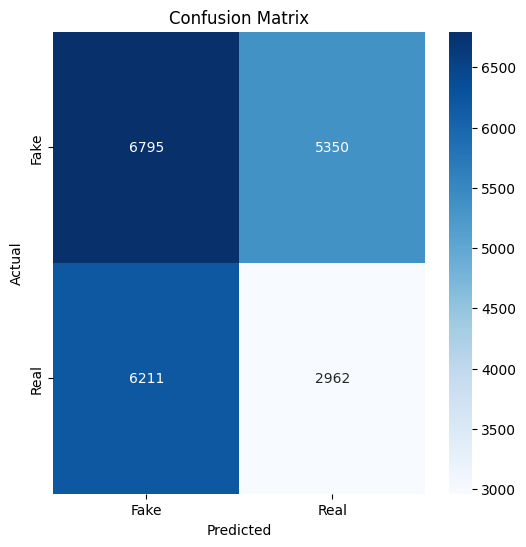

In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Evaluate on test data
loss, accuracy = model.evaluate(x_test_padded, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Confusion Matrix
y_pred = model.predict(x_test_padded)
y_pred_classes = (y_pred > 0.5).astype("int32")
conf_matrix = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

save the model & evalution

              precision    recall  f1-score   support

        Fake       0.52      0.56      0.54     12145
        Real       0.36      0.32      0.34      9173

    accuracy                           0.46     21318
   macro avg       0.44      0.44      0.44     21318
weighted avg       0.45      0.46      0.45     21318



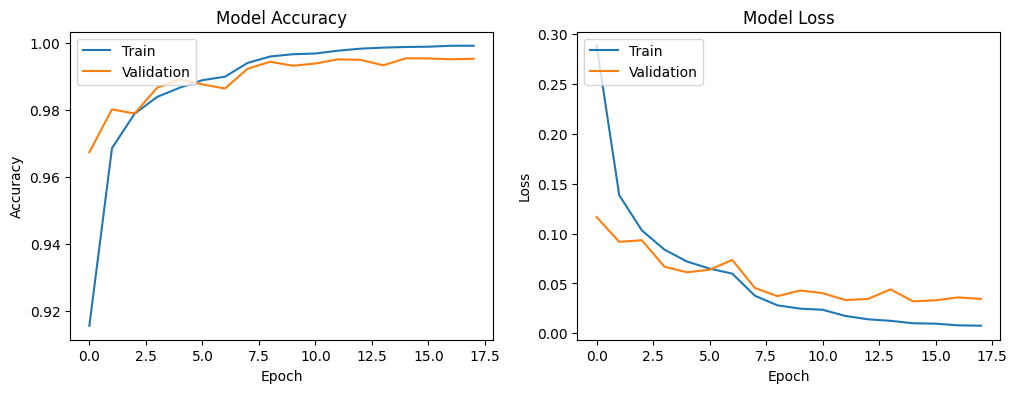

In [17]:
from sklearn.metrics import classification_report

# Classification Report
print(classification_report(y_test, y_pred_classes, target_names=['Fake', 'Real']))

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

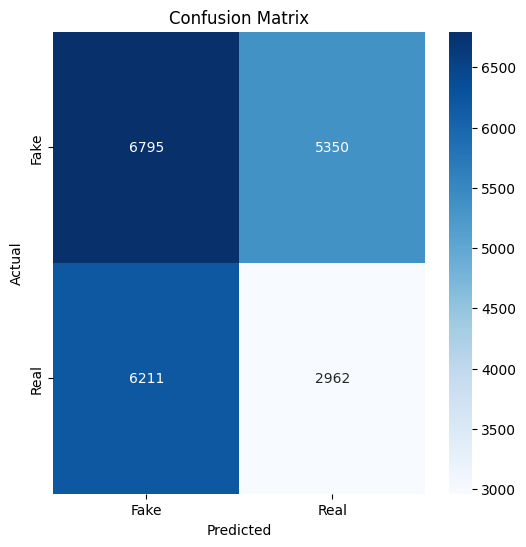

In [18]:
from sklearn.metrics import confusion_matrix

# Compute and plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Text(0, 0.5, 'Loss')

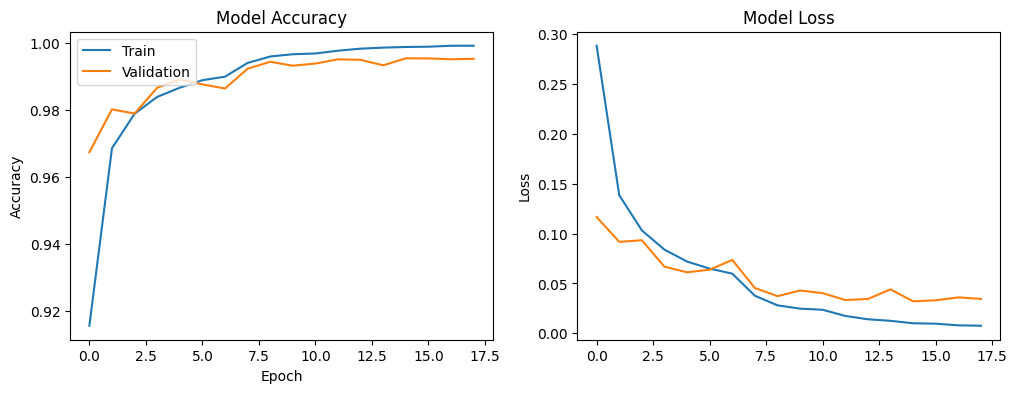

In [19]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')